# RNN:

>  Recurrent Neural Networks (RNNs) differ from regular neural networks in how they process information. While standard neural networks pass information in one direction i.e from input to output, RNNs feed information back into the network at each step.




<img src="https://miro.medium.com/v2/resize:fit:947/1*K6s4Li0fTl1pSX4-WPBMMA.jpeg" width="500">


In [1]:
!pip install torch torchvision torchaudio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 848.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Example corpus-data for simple RNN
text = "hello world. welcome to rnn text generation example."


In [7]:
# Create vocabulary
chars = sorted(list(set(text)))
char2idx = {ch: idx for idx, ch in enumerate(chars)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
chars , char2idx

([' ',
  '.',
  'a',
  'c',
  'd',
  'e',
  'g',
  'h',
  'i',
  'l',
  'm',
  'n',
  'o',
  'p',
  'r',
  't',
  'w',
  'x'],
 {' ': 0,
  '.': 1,
  'a': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'g': 6,
  'h': 7,
  'i': 8,
  'l': 9,
  'm': 10,
  'n': 11,
  'o': 12,
  'p': 13,
  'r': 14,
  't': 15,
  'w': 16,
  'x': 17})

In [5]:
# Encode text to integers
encoded = np.array([char2idx[c] for c in text])
encoded

array([ 7,  5,  9,  9, 12,  0, 16, 12, 14,  9,  4,  1,  0, 16,  5,  9,  3,
       12, 10,  5,  0, 15, 12,  0, 14, 11, 11,  0, 15,  5, 17, 15,  0,  6,
        5, 11,  5, 14,  2, 15,  8, 12, 11,  0,  5, 17,  2, 10, 13,  9,  5,
        1])

In [8]:

# Hyperparameters for data batching
seq_length = 10
def get_batches(arr, batch_size=4):
    total_len = len(arr) - seq_length
    for i in range(0, total_len, batch_size):
        x = arr[i:i+seq_length]
        y = arr[i+1:i+seq_length+1]
        yield torch.tensor(x).unsqueeze(0), torch.tensor(y).unsqueeze(0)

In [9]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(vocab_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


In [10]:
def train_rnn(hidden_size=32, learning_rate=0.01, epochs=50):
    vocab_size = len(chars)
    model = CharRNN(vocab_size, hidden_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []

    for epoch in range(epochs):
        hidden = model.init_hidden(1)
        total_loss = 0

        for x_batch, y_batch in get_batches(encoded):
            x_onehot = torch.nn.functional.one_hot(x_batch, num_classes=vocab_size).float()

            optimizer.zero_grad()
            out, hidden = model(x_onehot, hidden.detach())
            loss = criterion(out.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {total_loss:.4f}")

    # Plot loss curve
    plt.figure(figsize=(6,4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

    # Generate text
    print("\nGenerated text:")
    start = torch.tensor([char2idx['h']]).unsqueeze(0)
    hidden = model.init_hidden(1)
    input_seq = torch.nn.functional.one_hot(start, num_classes=vocab_size).float()
    result = ['h']

    for _ in range(50):
        out, hidden = model(input_seq, hidden)
        pred = torch.argmax(out, dim=2)[:,-1]
        char = idx2char[pred.item()]
        result.append(char)
        input_seq = torch.nn.functional.one_hot(pred.unsqueeze(0), num_classes=vocab_size).float()

    print("".join(result))


Epoch 0 - Loss: 30.6593
Epoch 10 - Loss: 5.1169
Epoch 20 - Loss: 0.6205
Epoch 30 - Loss: 0.2489
Epoch 40 - Loss: 0.1402


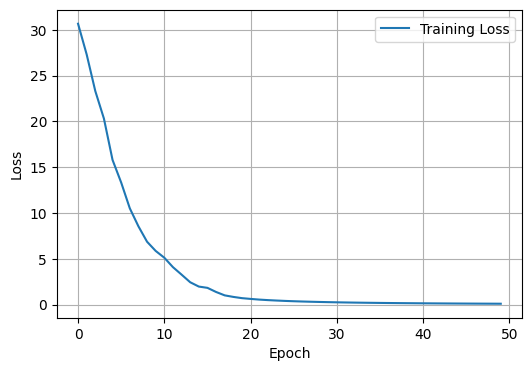


Generated text:
hello world. welcome to rnn text generation example


In [11]:
train_rnn()